In [1]:
import numpy as np

In [2]:
import pandas as pd
import pickle

In [5]:
import datetime

In [3]:
usd = pd.read_csv('USD_RUB_60m.txt')
brent = pd.read_csv('BRENT_60m.txt')
american_finance = pd.read_csv('AMERICAN_FINANCE_60m.txt')
rtsi = pd.read_csv('RTSI_60m.txt')

In [4]:
rtsi_ds = rtsi[['<DATE>','<TIME>','<RTSI_HIGH>','<RTSI_LOW>']]
usd_ds = usd[['<DATE>','<TIME>','<USD_HIGH>','<USD_LOW>']]
brent_ds = brent[['<DATE>','<TIME>','<BRENT_HIGH>','<BRENT_LOW>']]
american_finance_ds = american_finance[['<DATE>','<TIME>','<AF_HIGH>','<AF_LOW>']]

In [6]:
total_ds = pd.merge(left = usd_ds, right = brent_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how='outer')

In [7]:
total_ds = total_ds.merge(american_finance_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how = 'outer')

In [8]:
total_ds = total_ds.merge(rtsi_ds, left_on=('<DATE>','<TIME>'), right_on=('<DATE>','<TIME>'), how='outer')

In [9]:
total_ds['<WEEK_DAY>'] = list(map(lambda x: (datetime.datetime.strptime(str(x),'%Y%m%d').isoweekday()),total_ds['<DATE>']))

In [10]:
total_ds['<WEEK_NUM>'] = list(map(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').isocalendar()[1], total_ds['<DATE>']))

In [11]:
total_ds['<HOUR>'] = list(map(lambda x: int(x / 10000), total_ds['<TIME>']))

In [12]:
total_ds['<MONTH>'] = list(map(lambda x: int(str(x)[4:6]), total_ds['<DATE>']))

In [13]:
del total_ds['<DATE>']
del total_ds['<TIME>']

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class FillingFreeCellsLastValue(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        for column in self.column_names:
            list_ = X[column]
            list_ = np.nan_to_num(list_, nan = 0)
            tmp_val = np.median(list_[:100])
            for num,element in enumerate(list_):
                if element > 0:
                    tmp_val = element
                else:
                    list_[num] = tmp_val
            X[column] = list_
        return X

In [16]:
columns = ['<USD_HIGH>', '<USD_LOW>', 
           '<BRENT_HIGH>', '<BRENT_LOW>',
           '<AF_HIGH>', '<AF_LOW>',
           '<RTSI_HIGH>', '<RTSI_LOW>']

In [17]:
FillingFreeCellsLastValue(columns).fit_transform(total_ds)

,<USD_HIGH>,<USD_LOW>,<BRENT_HIGH>,<BRENT_LOW>,<AF_HIGH>,<AF_LOW>,<RTSI_HIGH>,<RTSI_LOW>,<WEEK_DAY>,<WEEK_NUM>,<HOUR>,<MONTH>
0,63.6750,63.6750,48.955,48.765,249.597468,249.279047,0.00,0.00,7,44,23,11
1,64.0934,62.3727,48.955,48.765,249.597468,249.279047,0.00,0.00,1,45,0,11
2,64.5614,64.0450,48.955,48.765,246.563256,246.542204,0.00,0.00,1,45,1,11
3,64.5622,63.5524,48.955,48.765,246.568520,246.542204,0.00,0.00,1,45,2,11
4,64.5603,62.6139,49.500,49.370,246.568520,246.557993,0.00,0.00,1,45,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...
28552,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1069.29,1065.60,6,52,17,12
28553,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1069.37,1066.87,6,52,18,12
28554,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1068.72,1066.11,6,52,19,12
28555,63.8336,63.7580,59.360,59.150,385.100154,385.073838,1547.20,1544.07,3,52,18,12


In [18]:
total_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28557 entries, 0 to 28556
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <USD_HIGH>    28557 non-null  float64
 1   <USD_LOW>     28557 non-null  float64
 2   <BRENT_HIGH>  28557 non-null  float64
 3   <BRENT_LOW>   28557 non-null  float64
 4   <AF_HIGH>     28557 non-null  float64
 5   <AF_LOW>      28557 non-null  float64
 6   <RTSI_HIGH>   28557 non-null  float64
 7   <RTSI_LOW>    28557 non-null  float64
 8   <WEEK_DAY>    28557 non-null  int64  
 9   <WEEK_NUM>    28557 non-null  int64  
 10  <HOUR>        28557 non-null  int64  
 11  <MONTH>       28557 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 2.8 MB


In [19]:
train_data = np.array(total_ds)

In [87]:
ds_x = []
ds_y_up = []
ds_y_down = []

days_hist= 40
days_predict = 10
hours_in_day = 24
num_history_values = hours_in_day * days_hist
num_predicted_value = hours_in_day * days_predict


for num, line in enumerate(train_data[:-(num_history_values+num_predicted_value)]):
    ds_x.append(train_data[num:num+num_history_values].reshape((train_data[num:num+num_history_values].size)))

for num, line in enumerate(train_data[num_history_values:-num_predicted_value]):
    x = train_data[num_history_values+num,0]
    y = np.max(train_data[num_history_values+num:num_history_values+num+num_predicted_value,0])
    res = (y/x-1)*100
    if res >= 4:
        ds_y_up.append(1)
    else:
        ds_y_up.append(0)
        
for num, line in enumerate(train_data[num_history_values:-num_predicted_value]):
    x = train_data[num_history_values+num,0]
    y = np.min(train_data[num_history_values+num:num_history_values+num+num_predicted_value,0])
    res = (y/x-1)*100
    if res < -4:
        ds_y_down.append(1)
    else:
        ds_y_down.append(0)
        

# for num in range(len(train_data[:-num_predicted_value-num_history_values])):
#     ds_hist.append(train_data[num+num_history_values:num+num_history_values+num_predicted_value,0])

In [97]:
def get_slice(x,idx):
    return x[idx+num_history_values:idx+num_history_values+num_predicted_value,0]

In [98]:
ds_hist = list(map(lambda a:get_slice(train_data,a), list(range(len(train_data[:-num_predicted_value-num_history_values])))))

In [32]:
# 
counter = 0
idxs = []
for idx,i in enumerate(ds_y):
    if i == 1:
        counter += 1
        idxs.append(idx)
print('percent up 4%=',counter*100/len(ds_y_up))
counter = 0
idxs = []
for idx,i in enumerate(ds_y_down):
    if i == 1:
        counter += 1
        idxs.append(idx)
print('percent down 4%=',counter*100/len(ds_y_down))

percent up 4%= 11.061154366341338
percent down 4%= 6.70760682823409


In [30]:
num = 550
x = train_data[num_history_values+num,0]
print(x)
y = np.min(train_data[num_history_values+num:num+num_history_values+num_predicted_value,[0]])
print(y)
z = np.max(train_data[num_history_values+num:num+num_history_values+num_predicted_value,[0]])
print(z)
print((x/z-1)*100)

78.5581
75.1518
82.2802
-4.523688566629636


In [33]:
ds_x = np.asarray(ds_x, dtype = np.float16)
ds_y_up = np.asarray(ds_y_up, dtype = np.bool).reshape(-1,1)
ds_y_down = np.asarray(ds_y_down, dtype = np.bool).reshape(-1,1)

In [186]:
t_ds = np.hstack((ds_y,ds_y_down))

In [192]:
t_ds[550]

array([ True,  True])

In [202]:
idx = np.array(range(len(ds_y)))

In [203]:
np.random.shuffle(idx)

In [204]:
ds_x = ds_x[idx]
t_ds = t_ds[idx]

In [205]:
from sklearn.model_selection import train_test_split

In [206]:
ds_x_train, ds_x_test, ds_y_train, ds_y_test =  train_test_split(ds_x, t_ds, test_size = 0.2, random_state = 42)

In [209]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [256]:
sgd_clf = SGDClassifier(n_jobs = -1)
dt_clf = DecisionTreeClassifier(max_depth = 100)
knn_clf = KNeighborsClassifier(n_neighbors=10, n_jobs = -1)
rf_clf = RandomForestClassifier(n_estimators=20, max_depth=40, n_jobs = -1)
mlp_clf = MLPClassifier(hidden_layer_sizes=(350))

In [211]:
from sklearn.metrics import f1_score

In [224]:
import time

In [257]:
current_time = time.time()
mlp_clf.fit(ds_x_train,ds_y_train[:,0])
elapsed_time = time.time() - current_time
elapsed_time/60

43.121704785029095

In [259]:
f1_score(ds_y_train[:,0], mlp_clf.predict(ds_x_train))

0.0

In [216]:
estimators = [sgd_clf, dt_clf, knn_clf, rf_clf, mlp_clf]
names = []
scores = []
for estimator in estimators:
    names.append(str(estimator).split(sep = '(')[0])
    estimator.fit(ds_x_train,ds_y_train[:,0])
    scores.append(f1_score(ds_y_train[:,0], estimator.predict(ds_x_train)))
    print('finish',str(estimator).split(sep = '(')[0])

finish SGDClassifier
finish DecisionTreeClassifier
finish KNeighborsClassifier
finish RandomForestClassifier
finish MLPClassifier


In [217]:
for name,score in zip(names,scores):
    print(name,score)

SGDClassifier 0.4907633321714883
DecisionTreeClassifier 1.0
KNeighborsClassifier 0.9666250779787897
RandomForestClassifier 0.9995393827729157
MLPClassifier 0.0


In [264]:
from sklearn.model_selection import cross_val_score

In [269]:
print('precision',min(cross_val_score(rf_clf, ds_x_train, ds_y_train[:,0], cv=5, scoring='precision', n_jobs = -1)))
print('accuracy',min(cross_val_score(rf_clf, ds_x_train, ds_y_train[:,0], cv=5, scoring='accuracy', n_jobs = -1)))

precision 0.9594383775351014
accuracy 0.9850951616601696


In [270]:
from sklearn.metrics import cohen_kappa_score

In [272]:
rf_clf.fit(ds_x_train, ds_y_train[:,0])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [275]:
y_pred = rf_clf.predict(ds_x_test)

In [279]:
x = cohen_kappa_score(ds_y_test[:,0],y_pred)

In [283]:
x

0.9630077254625548

In [37]:
knreg.fit(ds_x_train,ds_y_train)
predicted_values_knreg = knreg.predict(ds_x_test)

In [42]:
filename = 'finalized_model_kneighbours_regressor.sav'
pickle.dump(knreg, open(filename, 'wb'))

In [38]:
dtreg.fit(ds_x_train,ds_y_train)
predicted_values_dtreg = dtreg.predict(ds_x_test)

In [43]:
filename = 'finalized_model_dec_tree_regressor.sav'
pickle.dump(dtreg, open(filename, 'wb'))

In [39]:
mlpreg.fit(ds_x_train,ds_y_train)
predicted_values_mlp = mlpreg.predict(ds_x_test)

C:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
filename = 'finalized_model_mlp_regressor.sav'
pickle.dump(mlpreg, open(filename, 'wb'))

In [40]:
rfr.fit(ds_x_train,ds_y_train)
predicted_values_rfr = rfr.predict(ds_x_test)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [45]:
filename = 'finalized_model_rend_forest_regressor.sav'
pickle.dump(rfr, open(filename, 'wb'))

kneighbours predictions - blue,
decision tree prediction - green

In [261]:
import matplotlib.pyplot as plt

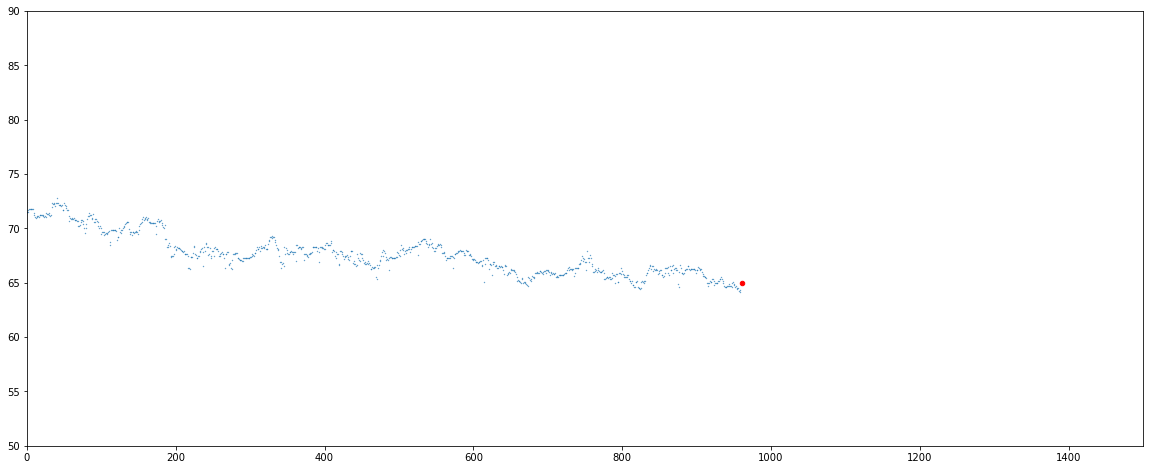

In [298]:
number = 5
combination = ds_x_test[number].reshape(num_history_values,-1)[:,1]
length = len(combination)
plt.figure(figsize=(20,8))
plt.ylim(50,90)
plt.xlim(0,1500)
plt.scatter(range(length),combination,s=0.1)
shift = 1 #num_predicted_value
plt.scatter(shift+length, ds_y_test[number,0]*65,s=20, color = 'red')
# plt.scatter(shift+length+5, predicted_values_knreg[number],s=20, color = 'blue')
# plt.scatter(shift+length+10, predicted_values_dtreg[number],s=20, color = 'green')
# plt.scatter(shift+length-10, predicted_values_mlp[number],s=20, color = 'yellow')
# plt.scatter(shift+length-5, predicted_values_rfr[number],s=20, color = 'black')

In [293]:
for num, value in enumerate(ds_y_test[:,0]):
    if value == 1:
        print(num)
        break
    

5


In [61]:
length+num_predicted_value

720

In [58]:
ds_x_test[1].reshape(num_history_values,-1)[:,1]

array([62.84, 62.84, 62.8 , 62.75, 62.75, 62.8 , 62.72, 62.84, 62.84,
       62.78, 62.66, 62.62, 62.62, 62.66, 62.53, 62.6 , 62.56, 62.53,
       62.62, 62.66, 62.72, 62.6 , 62.6 , 62.62, 62.66, 62.7 , 62.72,
       62.7 , 62.75, 62.75, 62.8 , 62.8 , 62.8 , 62.75, 62.9 , 62.8 ,
       62.84, 62.8 , 62.9 , 62.94, 62.97, 62.97, 62.97, 62.94, 62.97,
       63.  , 62.94, 62.94, 63.06, 62.97, 63.06, 63.1 , 63.16, 63.25,
       63.38, 63.38, 63.4 , 63.4 , 63.34, 63.38, 63.4 , 63.38, 63.38,
       63.34, 63.34, 63.38, 63.34, 63.34, 63.1 , 63.12, 63.1 , 63.16,
       63.12, 63.1 , 63.03, 63.06, 63.12, 63.12, 63.12, 63.16, 63.16,
       63.12, 63.03, 63.1 , 63.12, 63.12, 63.12, 63.  , 63.  , 63.03,
       63.1 , 63.06, 62.94, 62.94, 63.16, 63.2 , 63.16, 63.2 , 63.22,
       63.2 , 63.2 , 63.2 , 63.22, 63.2 , 63.22, 63.16, 63.16, 63.25,
       63.3 , 63.3 , 63.3 , 63.3 , 63.3 , 63.28, 63.22, 63.16, 63.1 ,
       63.06, 63.2 , 63.12, 63.12, 62.97, 62.88, 62.97, 63.  , 62.97,
       63.  , 63.  ,